## Importing Libraries

In [ ]:
!pip install PyPortfolioOpt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.1/220.1 kB 11.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage,dendrogram,fcluster
from sklearn.covariance import EmpiricalCovariance
from pypfopt.discrete_allocation import DiscreteAllocation,get_latest_prices
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage,sample_cov
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions,BlackLittermanModel,plotting

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [ ]:
import yfinance as yf

def stock_data(tickers,start_date,end_date):
    data=yf.download(tickers,start=start_date,end=end_date)['Close']
    return data

# Prompt user for input
user_tickers=input("Enter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: ").split(',')
start_date=input("Enter the start date (YYYY-MM-DD) or press Enter for default (2023-01-01): ")
end_date=input("Enter the end date (YYYY-MM-DD) or press Enter for default (2025-01-01): ")

# Set defaults if input is incomplete
default_tickers=['RELIANCE.NS','TCS.NS','INFY.NS','HDFCBANK.NS','ITC.NS']

# default_tickers=['BHARTIARTL.NS', 'LTIM.NS', 'HDFCLIFE.NS', 'NTPC.NS', 'MARUTI.NS',
#                    'NESTLEIND.NS', 'BAJFINANCE.NS', 'KOTAKBANK.NS', 'TATASTEEL.NS',
#                    'ONGC.NS', 'BAJAJ-AUTO.NS', 'LT.NS', 'ITC.NS', 'TCS.NS', 'BRITANNIA.NS',
#                    'SHRIRAMFIN.NS', 'ADANIENT.NS', 'CIPLA.NS', 'WIPRO.NS', 'INDUSINDBK.NS',
#                    'ULTRACEMCO.NS', 'TATACONSUM.NS', 'BAJAJFINSV.NS', 'RELIANCE.NS',
#                    'HEROMOTOCO.NS', 'COALINDIA.NS', 'TITAN.NS', 'HINDALCO.NS',
#                    'APOLLOHOSP.NS','TECHM.NS','DRREDDY.NS','DIVISLAB.NS','EICHERMOT.NS','BPCL.NS','SBILIFE.NS',
#                    'LTIM.NS','GRASIM.NS','JSWSTEEL.NS','ASIANPAINT.NS','POWERGRID.NS','ADANIPORTS.NS','M&M.NS',
#                    'TATAMOTORS.NS','SUNPHARMA.NS','AXISBANK.NS','HCLTECH.NS','HINDUNILVR.NS','INFY.NS','SBIN.NS',
#                    'ICICIBANK.NS','HDFCBANK.NS']

# default_tickers = [
#     "AAPL", "MSFT", "AMZN", "NVDA", "GOOGL", "TSLA", "BRK-B", "JNJ", "WMT", "JPM",
#     "V", "PG", "UNH", "HD", "BAC", "MA", "DIS", "XOM", "KO", "PFE",
#     "CVX", "MRK", "PEP", "ABBV", "TMO", "LLY", "AVGO", "CSCO", "COST", "DHR",
#     "ACN", "MCD", "NKE", "WFC", "NEE", "INTC", "TXN", "LIN", "MDT", "HON",
#     "LOW", "PM", "IBM", "UPS", "QCOM", "AMGN", "ORCL", "RTX", "NFLX", "BA"
# ]

default_start_date='2023-01-01'
default_end_date='2025-01-01'

tickers=user_tickers if any(user_tickers) else default_tickers
start_date=start_date if start_date else default_start_date
end_date=end_date if end_date else default_end_date

data=stock_data(tickers,start_date,end_date)

Enter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: 
Enter the start date (YYYY-MM-DD) or press Enter for default (2023-01-01): 
Enter the end date (YYYY-MM-DD) or press Enter for default (2025-01-01): 


[*********************100%***********************]  5 of 5 completed


In [ ]:
initial_capital=1000000

In [ ]:
returns=data.pct_change().dropna()
returns=returns.dropna()
# Distance Matrix and Clustering
correlation=returns.corr()
distance_matrix=np.sqrt(2*(1-correlation))
linked=linkage(distance_matrix,method='ward')

## Form Clusters

In [ ]:
# Cluster stocks
linked = linkage(data.T, method='ward')
num_clusters = 2

clusters = fcluster(linked, num_clusters, criterion='maxclust')
tickers = list(data.columns)
cluster_map = {tickers[i]: clusters[i] for i in range(len(tickers))}
print("Clusters:", cluster_map)

Clusters: {'HDFCBANK.NS': 1, 'INFY.NS': 1, 'ITC.NS': 1, 'RELIANCE.NS': 1, 'TCS.NS': 2}


In [ ]:
# Divide initial capital equally among clusters
initial_capital = 1000000
cluster_capital = initial_capital / num_clusters

# Initialize total portfolio weights
total_weights = {}

## Optimizing each Cluster

In [ ]:
# Optimize weights within each cluster
for cluster_id in range(1, num_clusters + 1):
    cluster_stocks = [stock for stock, cluster in cluster_map.items() if cluster == cluster_id]

    # Check if the cluster has any stocks
    if not cluster_stocks:
        print(f"Cluster {cluster_id} is empty. Skipping...")
        continue  # Skip to the next cluster

    cluster_data = data[cluster_stocks]

    # Calculate mean returns and covariance matrix
    mean_returns = mean_historical_return(cluster_data)
    cov_matrix = CovarianceShrinkage(cluster_data).ledoit_wolf()

    # Optimize weights for the cluster
    def calculate_weights(ret_bl, S_bl):
        ef = EfficientFrontier(ret_bl, S_bl)
        ef.add_objective(objective_functions.L2_reg)
        ef.max_sharpe()
        weights = ef.clean_weights()
        return weights

    cluster_weights = calculate_weights(mean_returns, cov_matrix)
    total_weights.update(cluster_weights)

print("Optimal Weights:", total_weights)

Optimal Weights: {'HDFCBANK.NS': 0.12193, 'INFY.NS': 0.30446, 'ITC.NS': 0.54635, 'RELIANCE.NS': 0.02726, 'TCS.NS': 1.0}


## Covariance Heatmap

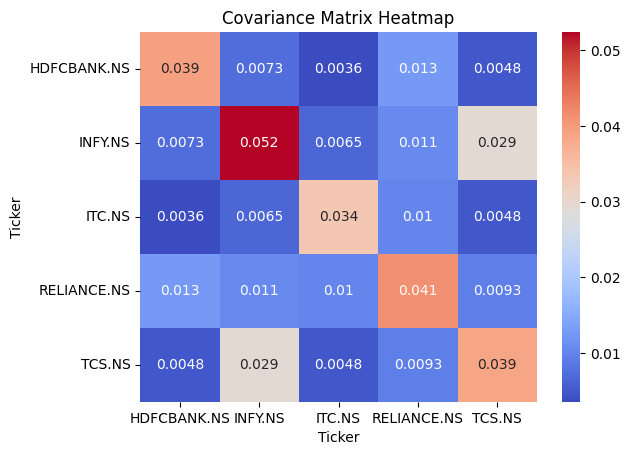

In [ ]:
mean_returns=mean_historical_return(data)
cov_matrix=CovarianceShrinkage(data).ledoit_wolf()
sns.heatmap(cov_matrix,cmap='coolwarm',annot=True,xticklabels=tickers,yticklabels=tickers)
plt.title("Covariance Matrix Heatmap")
plt.show()

## Discrete Allocation

In [ ]:
# Perform discrete allocation
latest_prices = data.iloc[-1]

def discrete_allocation(weights, initial_capital):
    da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=initial_capital)
    alloc, leftover = da.lp_portfolio()
    for stock in weights:
        if stock not in alloc:
            alloc[stock] = 0
    return alloc, leftover

alloc, leftover = discrete_allocation(total_weights, initial_capital)
print("Discrete Allocation:", alloc)
print("Funds Remaining:", leftover)

Discrete Allocation: {'HDFCBANK.NS': 64, 'INFY.NS': 23, 'ITC.NS': 1119, 'RELIANCE.NS': 20, 'TCS.NS': 68}
Funds Remaining: -1.979060471057892e-09


## Visualize Allocation

In [ ]:
mcaps={}
for t in tickers:
    stock=yf.Ticker(t)
    mcaps[t]=stock.info["marketCap"]
mcaps

{'HDFCBANK.NS': 12629255913472,
 'INFY.NS': 7510851846144,
 'ITC.NS': 5476371136512,
 'RELIANCE.NS': 17665869479936,
 'TCS.NS': 14753847050240}

In [ ]:
# Function to plot market cap vs optimal weights
def plot_weights(weights, mcaps):
    mcaps_series = pd.Series(mcaps)
    market_cap_weights = mcaps_series / mcaps_series.sum()

    weights_df = pd.DataFrame({
        'Market Cap Weights': market_cap_weights,
        'Optimal Weights': weights
    })

    weights_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Market Cap Weights vs Optimal Weights')
    plt.ylabel('Weights')
    plt.xlabel('Stocks')
    plt.xticks(rotation=45)
    plt.legend(loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

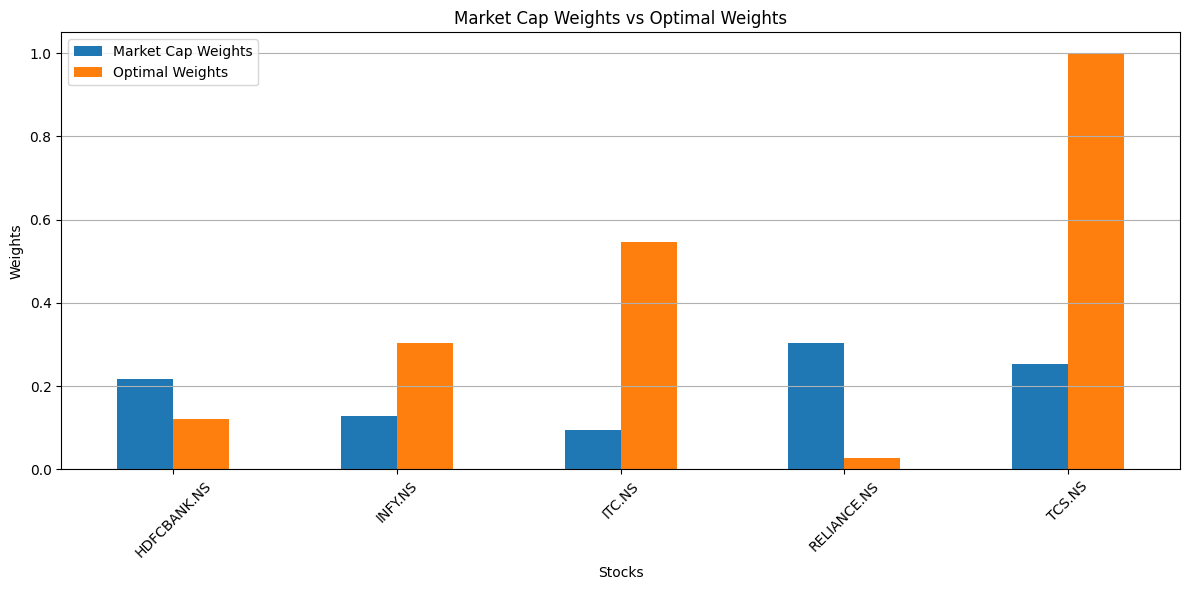

In [ ]:
plot_weights(total_weights,mcaps)

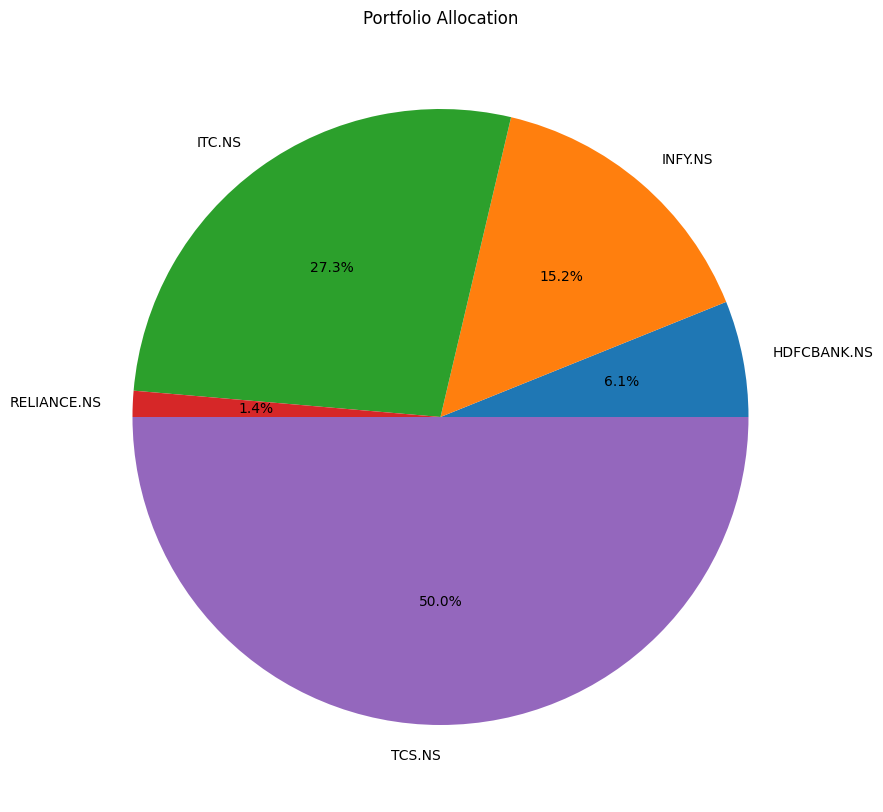

In [ ]:
# Function to plot pie chart of portfolio allocation
def plot_pie(weights):
    pd.Series(weights).plot.pie(figsize=(10, 10), autopct='%1.1f%%')

# Plotting portfolio allocation
plt.figure(figsize=(8, 8))
plot_pie(total_weights)
plt.title("Portfolio Allocation")
plt.show()

## Dendrogram

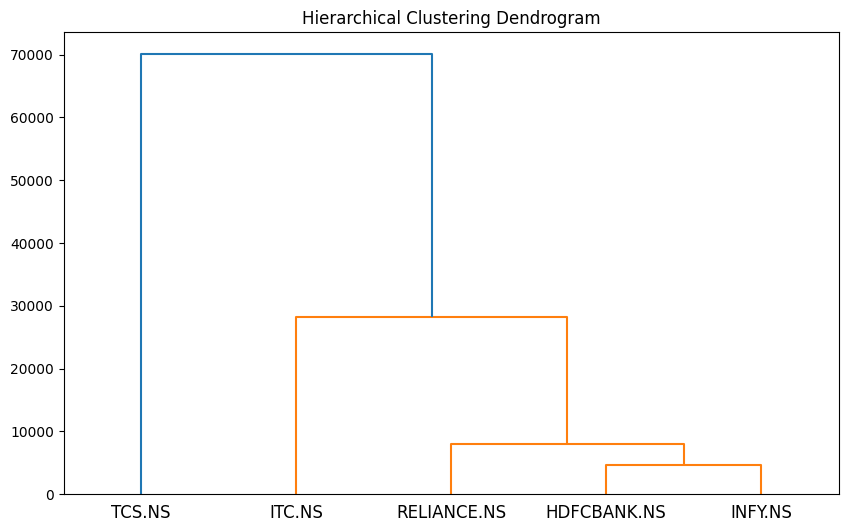

In [ ]:
# Hierarchical Clustering Dendrogram
plt.figure(figsize=(10, 6))
linked = linkage(data.T, method='ward')
dendrogram(linked, labels=data.columns, orientation='top',
               distance_sort='ascending', show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

## Projected Prices

In [ ]:
# Calculate projected prices
last_prices=data.iloc[-1]
percentage_changes=(data.iloc[-2]-data.iloc[1])/data.iloc[1]*100
projected_prices=last_prices*(1+percentage_changes/100)

## Performance Metrics

In [ ]:
# Portfolio metrics
def portfolio_metrics(alloc,projected_prices,latest_prices,risk_free_rate=0.03):
    returns=(projected_prices-latest_prices)/latest_prices
    total_investment=sum(alloc[stock]*latest_prices[stock] for stock in alloc)
    portfolio_return=sum(alloc[stock]*returns[stock]*latest_prices[stock] for stock in alloc) / total_investment
    weights=np.array([alloc[stock]*latest_prices[stock] / total_investment for stock in alloc])
    portfolio_std_dev=np.sqrt(np.dot(weights.T,np.dot(np.diag(returns**2), weights)))
    excess_return=portfolio_return-risk_free_rate
    sharpe_ratio=excess_return/portfolio_std_dev if portfolio_std_dev > 0 else 0
    return portfolio_return,sharpe_ratio

portfolio_return,sharpe_ratio=portfolio_metrics(alloc,projected_prices,last_prices)

print(f"Expected Portfolio Return: {portfolio_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Expected Portfolio Return: 40.44%
Sharpe Ratio: 1.24
